## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [53]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [54]:
df.shape

(1462, 9)

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [55]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [56]:
categorical = df.select_dtypes(include=['object']).columns.tolist()
numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

In [57]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [58]:
from sklearn.metrics import roc_auc_score

features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

for f in features:
    score = roc_auc_score(y_train, df_train[f])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[f])
    print(f"{f}: {score:.3f}")

lead_score: 0.614
number_of_courses_viewed: 0.764
interaction_count: 0.738
annual_income: 0.552


> number_of_courses_viewed

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [59]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Gabungkan fitur
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

# One-hot encoding
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Prediksi probabilitas
y_pred = model.predict_proba(X_val)[:, 1]

# Hitung AUC
auc = roc_auc_score(y_val, y_pred)
print(f"AUC: {auc:.3f}")

AUC: 0.817


> 0.72

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

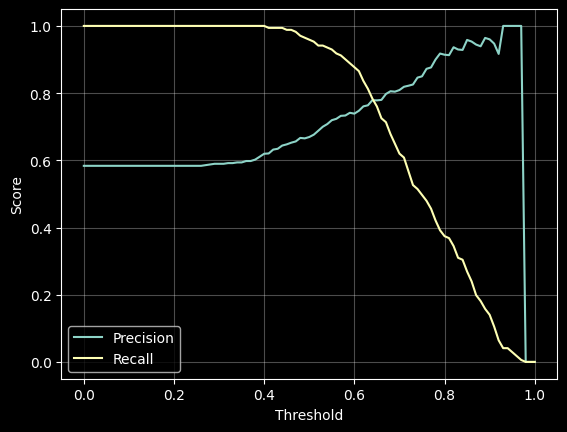

Threshold where precision and recall intersect: 0.640
Precision: 0.779
Recall: 0.784


In [60]:
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_label = (y_pred >= t).astype(int)
    p = precision_score(y_val, y_pred_label, zero_division=0)
    r = recall_score(y_val, y_pred_label, zero_division=0)
    precisions.append(p)
    recalls.append(r)

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Cari persilangan dengan mendeteksi perubahan tanda
precisions = np.array(precisions)
recalls = np.array(recalls)

intersection_idx = None
for i in range(len(thresholds)-1):
    # Cek apakah ada persilangan (perubahan tanda dari selisih)
    if (precisions[i] - recalls[i]) * (precisions[i+1] - recalls[i+1]) < 0:
        # Pilih yang paling dekat
        if abs(precisions[i] - recalls[i]) < abs(precisions[i+1] - recalls[i+1]):
            intersection_idx = i
        else:
            intersection_idx = i + 1
        break

if intersection_idx is not None:
    print(f"Threshold where precision and recall intersect: {thresholds[intersection_idx]:.3f}")
    print(f"Precision: {precisions[intersection_idx]:.3f}")
    print(f"Recall: {recalls[intersection_idx]:.3f}")
else:
    print("No intersection found")

> 0.545

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [61]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_label = (y_pred >= t).astype(int)
    p = precision_score(y_val, y_pred_label, zero_division=0)
    r = recall_score(y_val, y_pred_label, zero_division=0)
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * p * r / (p + r)
    f1_scores.append(f1)

max_f1_idx = np.argmax(f1_scores)
print(f"Threshold with maximal F1: {thresholds[max_f1_idx]:.3f}")
print(f"Max F1 score: {f1_scores[max_f1_idx]:.3f}")

Threshold with maximal F1: 0.570
Max F1 score: 0.812


> 0.54

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [62]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train_cv = df_full_train.iloc[train_idx].reset_index(drop=True)
    df_val_cv = df_full_train.iloc[val_idx].reset_index(drop=True)
    
    y_train_cv = df_train_cv.converted.values
    y_val_cv = df_val_cv.converted.values
    
    del df_train_cv['converted']
    del df_val_cv['converted']
    
    train_dict_cv = df_train_cv.to_dict(orient='records')
    val_dict_cv = df_val_cv.to_dict(orient='records')
    
    dv_cv = DictVectorizer(sparse=False)
    X_train_cv = dv_cv.fit_transform(train_dict_cv)
    X_val_cv = dv_cv.transform(val_dict_cv)
    
    model_cv = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = model_cv.predict_proba(X_val_cv)[:, 1]
    
    auc_cv = roc_auc_score(y_val_cv, y_pred_cv)
    auc_scores.append(auc_cv)

std_auc = np.std(auc_scores)
print("AUC scores for each fold:", [f"{score:.3f}" for score in auc_scores])
print(f"Standard deviation of AUC: {std_auc:.3f}")

AUC scores for each fold: ['0.806', '0.871', '0.775', '0.802', '0.856']
Standard deviation of AUC: 0.036


> 0.06

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [63]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

C_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

results = []

for C in C_values:
    auc_scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        df_train_cv = df_full_train.iloc[train_idx].reset_index(drop=True)
        df_val_cv = df_full_train.iloc[val_idx].reset_index(drop=True)
        
        y_train_cv = df_train_cv.converted.values
        y_val_cv = df_val_cv.converted.values
        
        del df_train_cv['converted']
        del df_val_cv['converted']
        
        train_dict_cv = df_train_cv.to_dict(orient='records')
        val_dict_cv = df_val_cv.to_dict(orient='records')
        
        dv_cv = DictVectorizer(sparse=False)
        X_train_cv = dv_cv.fit_transform(train_dict_cv)
        X_val_cv = dv_cv.transform(val_dict_cv)
        
        model_cv = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_cv.fit(X_train_cv, y_train_cv)
        y_pred_cv = model_cv.predict_proba(X_val_cv)[:, 1]
        
        auc_cv = roc_auc_score(y_val_cv, y_pred_cv)
        auc_scores.append(auc_cv)
    
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    results.append((C, mean_auc, std_auc))
    print(f"C={C}: mean AUC={mean_auc:.3f}, std={std_auc:.3f}")

# Pilih C dengan mean tertinggi, jika ada yang sama pilih std terendah, jika masih sama pilih C terkecil
results_sorted = sorted(results, key=lambda x: (-x[1], x[2], x[0]))
best_C = results_sorted[0][0]
print(f"Best C: {best_C}")

C=1e-06: mean AUC=0.560, std=0.024


C=0.001: mean AUC=0.867, std=0.029
C=1: mean AUC=0.822, std=0.036
Best C: 0.001


> 0.001

## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2025/homework/hw04
* If your answer doesn't match options exactly, select the closest one